In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import psycopg2

## 1. 데이터 LOAD

In [2]:
conn = psycopg2.connect("host=15.165.18.39 port=5432 user=linkshops password=$dpdlvmflf4 dbname=LINKSHOPS-20211121")

curs = conn.cursor()

In [3]:
#SQL = "SELECT * FROM ( SELECT ROW_NUMBER () OVER (ORDER BY 'id'), * FROM brands) x WHERE ROW_NUMBER BETWEEN 1 AND 30;"

In [4]:
SQL = "SELECT * FROM tb_seller_packing_info"

In [5]:
curs.execute(SQL)

In [6]:
dataframe = pd.DataFrame(curs)

In [7]:
SQL = "SELECT column_name FROM INFORMATION_SCHEMA.COLUMNS WHERE table_name = 'tb_seller_packing_info'"

In [8]:
curs.execute(SQL)

In [9]:
dataframe.columns = [i[0] for i in curs]

In [10]:
dataframe['orderProductExtraId'].isna().value_counts()

True     2620739
False      34699
Name: orderProductExtraId, dtype: int64

In [11]:
SQL_2 = "select * from wait_shipment_logs where \"createdAt\" between '2018-07-09' and '2021-11-21'"

In [12]:
curs.execute(SQL_2)

In [13]:
dataframe_2 = pd.DataFrame(curs)

In [14]:
SQL_2 = "SELECT column_name FROM INFORMATION_SCHEMA.COLUMNS WHERE table_name = 'wait_shipment_logs'"

In [15]:
curs.execute(SQL_2)

In [16]:
dataframe_2.columns = [i[0] for i in curs]

In [17]:
SQL_3 = "select * from tb_buyers"

In [18]:
curs.execute(SQL_3)

In [19]:
dataframe_3 = pd.DataFrame(curs)

In [20]:
SQL_3 = "SELECT column_name FROM INFORMATION_SCHEMA.COLUMNS WHERE table_name = 'tb_buyers'"

In [21]:
curs.execute(SQL_3)

In [22]:
dataframe_3.columns = [i[0] for i in curs]

# 2. EDA

## 0) 데이터 현황 파악

In [23]:
np.max(dataframe['createdAt'])

Timestamp('2021-11-21 05:53:13.780939+0000', tz='UTC')

In [24]:
np.min(dataframe['createdAt'])

Timestamp('2018-07-09 06:32:24.824675+0000', tz='UTC')

In [25]:
np.max(dataframe_2['createdAt'])

Timestamp('2021-11-20 05:55:29.551161+0000', tz='UTC')

In [26]:
np.min(dataframe_2['createdAt'])

Timestamp('2018-07-09 00:00:18.763019+0000', tz='UTC')

In [27]:
dataframe.describe().T

count          mean           std        min  \
id                   2655438.0  1.327727e+06  7.665630e+05        1.0   
orderProductId       2655438.0  1.028645e+07  3.574780e+06  2229655.0   
orderProductExtraId    34699.0  4.247172e+05  1.635534e+05    62986.0   
packedQuantity       2655438.0  2.696125e+00  2.215582e+02        0.0   
status               2655438.0  3.389271e-03  5.821647e-01        0.0   
sellerId             2655438.0  4.947202e+04  3.324318e+04        3.0   

                            25%         50%          75%         max  
id                    663863.25   1327731.5   1991590.75   2655450.0  
orderProductId       7421889.50  10560108.5  13395985.75  16001381.0  
orderProductExtraId   302910.00    450021.0    558145.50    695523.0  
packedQuantity             0.00         1.0         1.00     79000.0  
status                     0.00         0.0         0.00       100.0  
sellerId               22570.00     45408.0     69976.00    147826.0

In [28]:
dataframe['status'].unique()

array([  0, 100], dtype=int64)

- 연속형 변수의 경우, orderProductExtraId는 절대다수가 결측이다
- packedQuantity의 경우, 백분위수 기준으로 75%까지 1이나, 소수의 Outliar가 존재한다.(평균 2.69, 표준편차 221). 우로 긴 Longtail
- status의 경우 0, 100의 두 종류의 값을 가진다.

In [29]:
dataframe['arriveAt'].isna().value_counts()

True     2397475
False     257963
Name: arriveAt, dtype: int64

In [30]:
temp = pd.concat([dataframe['arriveAt'].isna(),
           dataframe['updatedAt'].apply(lambda x : x.year)], axis = 1)

In [31]:
a = temp.groupby('updatedAt')['arriveAt'].value_counts()

a.name = 'value'

a = a.reset_index()

a

updatedAt  arriveAt   value
0       2018      True  157925
1       2018     False   22661
2       2019      True  859293
3       2019     False   98799
4       2020      True  770833
5       2020     False   76560
6       2021      True  609424
7       2021     False   59943

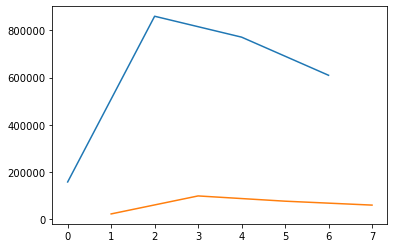

In [21]:
plt.plot(a.loc[a['arriveAt'] == True,'value'])
plt.plot(a.loc[a['arriveAt'] == False,'value'])

- arriveAt의 경우 절대다수가 결측값이다. 그러나, 결측값이 아닌 경우도 만만치않게 많으므로, 확인이 필요하다.
- 연도별로 확인해봤을때도, 연도가 지나면서 결측값이 줄어들거나, 반대로 늘어나는 패턴은 찾아보기 어렵다.

## 1) arriveAt 기반 분석

### (1) 가설 1 : arriveAt이 NaT이 아닌 사례는 미송 등의 재발송 필요 사례일 것이다.

#### - packedQuantity와의 교차 분석

Text(0, 0.5, 'Frequency')

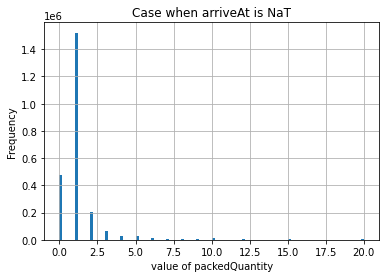

In [22]:
dataframe.loc[dataframe['arriveAt'].isna(), 'packedQuantity'].hist(bins = 100,range = (0,20))
plt.title('Case when arriveAt is NaT')
plt.xlabel('value of packedQuantity')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

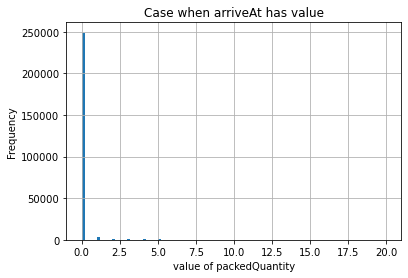

In [23]:
dataframe.loc[~dataframe['arriveAt'].isna(), 'packedQuantity'].hist(bins = 100,range = (0,20))
plt.title('Case when arriveAt has value')
plt.xlabel('value of packedQuantity')
plt.ylabel('Frequency')

위 히스토그램을 통해 다음 결과를 지지할 수 있다.
- arriveAt이 결측일경우(즉 값이 없을 경우) 그 값은 대다수가 1 이상이다.
- arriveAt이 값이 있을 경우(즉 결측이 아닐 경우) 그 값은 절대다수가 0이다.

In [24]:
print('arriveAt이 결측일 때 packedQuantity')

dataframe.loc[dataframe['arriveAt'].isna(), 'packedQuantity']

arriveAt이 결측일 때 packedQuantity


0          1
1          1
2          1
3          1
4          1
          ..
2655433    2
2655434    1
2655435    1
2655436    1
2655437    1
Name: packedQuantity, Length: 2397475, dtype: int64

In [25]:
print('arriveAt이 결측이 아닐 때 packedQuantity')

dataframe.loc[~dataframe['arriveAt'].isna(), 'packedQuantity']

arriveAt이 결측이 아닐 때 packedQuantity


24         0
31         0
32         0
77         0
125        0
          ..
2655360    0
2655366    0
2655367    0
2655377    0
2655378    0
Name: packedQuantity, Length: 257963, dtype: int64

#### - T검정

육안으로 판단할 땐 packedQuantity에 명확한 차이가 보이나, 통계적으로 이를 엄밀히 검증한다.

t검정을 실시하기에 앞서, 기본 가정인 등분산성 검정을 levene의 방법으로 실시한다.

In [26]:
# 등분산 가정을 만족하지 못하므로 이분산 t-test를 실시한다.

a = pd.DataFrame(stats.levene(dataframe.loc[dataframe['arriveAt'].isna(), 'packedQuantity'],
            dataframe.loc[~dataframe['arriveAt'].isna(), 'packedQuantity'])).T
a.columns = ['levene_statistics','p-value']

a

levene_statistics   p-value
0          21.927277  0.000003

In [27]:
a = pd.DataFrame(stats.ttest_ind(dataframe.loc[dataframe['arriveAt'].isna(), 'packedQuantity'],
            dataframe.loc[~dataframe['arriveAt'].isna(), 'packedQuantity'], 
                equal_var = False)).T
a.columns = ['T-statistics','p-value']

a

T-statistics       p-value
0     18.257584  1.821889e-74

T검정 결과도 이를 지지하고 있다.(p_value <= 1.82e-74)

즉, ArriveAt이 결측일 때 packedQuantity 확률변수의 평균과, 그렇지 않을때의 확률변수의 평균은 다르다.

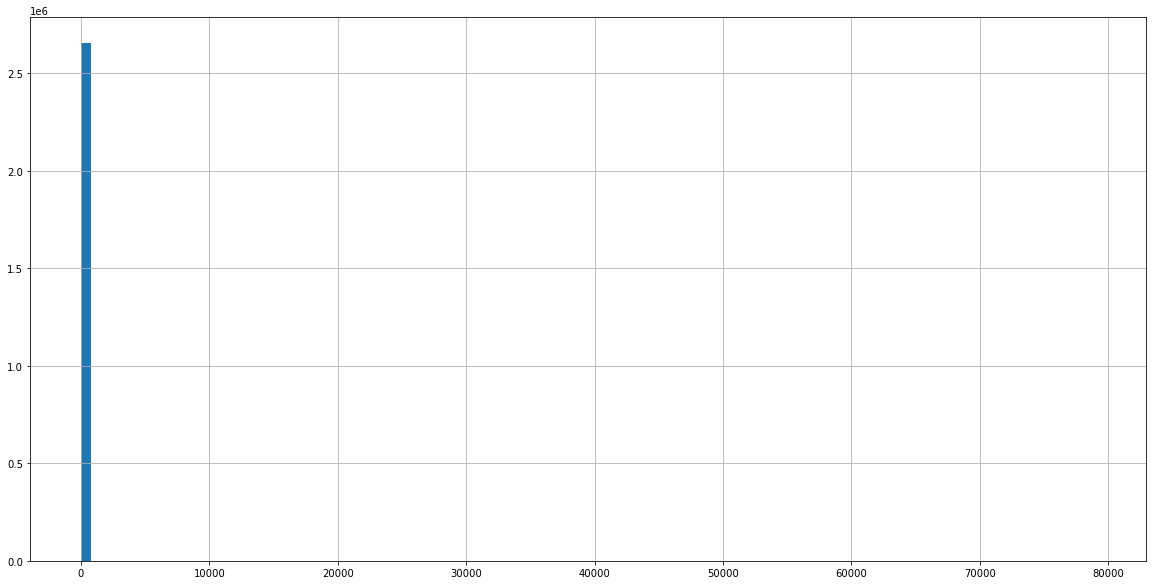

In [28]:
plt.figure(figsize = (20,10))
dataframe['packedQuantity'].hist(bins = 100)
plt.show()

In [29]:
plt.boxplot(dataframe.loc[dataframe['arriveAt'].isna(), 'packedQuantity'])
plt.show()

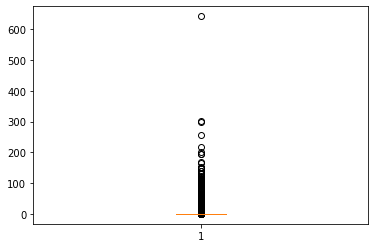

In [557]:
plt.boxplot(dataframe.loc[~dataframe['arriveAt'].isna(), 'packedQuantity'])
plt.show()

In [538]:
dataframe.loc[dataframe['arriveAt'].isna(), 'packedQuantity'][dataframe.loc[dataframe['arriveAt'].isna(), 'packedQuantity'] > 10000]

140533     29000
140534     29000
140537     25000
237981     14000
237982     14000
           ...  
2305813    12000
2305814    12000
2305816    12000
2305817    12000
2305820    12000
Name: packedQuantity, Length: 97, dtype: int64

In [555]:
dataframe.loc[~dataframe['arriveAt'].isna(), 'packedQuantity'][dataframe.loc[~dataframe['arriveAt'].isna(), 'packedQuantity'] > 100]

9066       120
24005      117
304169     120
312732     642
330688     115
387531     300
438369     107
438371     148
441028     120
494289     194
505394     302
513350     101
513351     110
540376     109
663419     152
666899     149
683049     140
683050     170
706549     150
710647     200
717192     196
792932     150
810035     130
850044     105
862241     112
878868     256
888017     217
973584     107
973585     134
1133233    110
1512657    138
1715647    148
1880850    110
1931075    122
1972615    165
Name: packedQuantity, dtype: int64

In [535]:
dataframe.iloc[1547026:1547029]

id  orderProductId  orderProductExtraId  \
1547026  1654340        12080649             588698.0   
1547027  1654338        12080650             588699.0   
1547028  1654337        12080627             588676.0   

         sellerPermitWaitShipment  packedQuantity  discontinued arriveAt  \
1547026                     False           79000         False      NaT   
1547027                     False           79000         False      NaT   
1547028                     False           39000         False      NaT   

        sellerMemo  status                        createdAt  \
1547026       None       0 2020-07-26 15:00:15.746677+00:00   
1547027       None       0 2020-07-26 15:00:15.746677+00:00   
1547028       None       0 2020-07-26 15:00:15.746677+00:00   

                               updatedAt  sellerId  
1547026 2020-07-26 19:59:15.286845+00:00      3585  
1547027 2020-07-26 19:59:15.286845+00:00      3585  
1547028 2020-07-26 19:59:15.286845+00:00      3585

{'whiskers': [<matplotlib.lines.Line2D at 0x1cf105871c0>,
 'caps': [<matplotlib.lines.Line2D at 0x1cf105878e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1cf1057cf10>],
 'medians': [<matplotlib.lines.Line2D at 0x1cf10592040>],
 'fliers': [<matplotlib.lines.Line2D at 0x1cf105923d0>],
 'means': []}

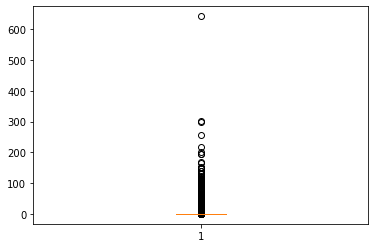

In [527]:
plt.boxplot(dataframe.loc[~dataframe['arriveAt'].isna(), 'packedQuantity'])

ArriveAt이 결측일 경우 1 이상이고, ArriveAt이 값이 존재할 경우 대부분 0이다.

### 결론 : arriveAt이 기재되어 있는 경우 PackedQuantity가 높은 확률로 0이다.
### 재발송 기한을 의미한다고 볼 수 있다.

## 2) packedQuantity 기반 분석

### (1) productQuantity가 모두 0인 사례 분석

가설을 세우지 않고, 밑바닥부터 자유롭게 분석한다.

In [30]:
result = dataframe.groupby('orderProductId')['packedQuantity'].apply(lambda x : x.sum())

In [31]:
packedQuantity_unique = result.reset_index()

In [32]:
packedQuantity_unique.loc[packedQuantity_unique['packedQuantity'] < 1]

orderProductId  packedQuantity
2               2520962               0
3               2526087               0
6               2609293               0
7               2648591               0
15              2703182               0
...                 ...             ...
2180313        15996101               0
2180316        15996476               0
2180317        15996477               0
2180318        15996478               0
2180319        15996479               0

[316242 rows x 2 columns]

위 OrderProductId는 packedQuantity가 모두 0인 사례를 나타낸것이다.

한 개짜리 행이라도, 열 개짜리 행이라도 packedQuantity가 0으로서, 상품이 '미송'으로 끝난 사례들로 일단 추정 할수있다.

In [33]:
dataframe[dataframe['orderProductId'] == packedQuantity_unique.loc[packedQuantity_unique['packedQuantity'] < 1, 'orderProductId'].iloc[0]]

id  orderProductId  orderProductExtraId  sellerPermitWaitShipment  \
2627484   9059         2520962                  NaN                      True   
2628442   7221         2520962                  NaN                      True   
2632399  10013         2520962                  NaN                      True   
2638294  17792         2520962                  NaN                      True   

         packedQuantity  discontinued                  arriveAt   sellerMemo  \
2627484               0         False 2018-08-03 00:00:00+00:00         10장씩   
2628442               0         False 2018-08-01 09:00:00+00:00  10장이상 가격입니다   
2632399               0         False                       NaT     휴가끝나고됩니다   
2638294               0          True                       NaT         None   

         status                        createdAt  \
2627484       0 2018-07-29 14:50:45.092470+00:00   
2628442       0 2018-07-26 15:29:31.448058+00:00   
2632399       0 2018-07-30 14:20:19.885078+00:00   
2638294       0 2018-08-15 14:35:11.417075+00:00   

                               updatedAt  sellerId  
2627484 2018-07-29 22:43:17.492564+00:00     27251  
2628442 2018-07-26 22:07:06.215001+00:00     27251  
2632399 2018-07-30 22:08:24.591253+00:00     27251  
2638294 2018-08-16 01:35:20.019228+00:00     27251

In [34]:
dataframe[dataframe['orderProductId'] == packedQuantity_unique.loc[packedQuantity_unique['packedQuantity'] < 1, 'orderProductId'].iloc[1]]

id  orderProductId  orderProductExtraId  sellerPermitWaitShipment  \
2628586  7371         2526087                  NaN                      True   
2631757  8269         2526087                  NaN                      True   

         packedQuantity  discontinued                  arriveAt sellerMemo  \
2628586               0         False 2018-07-31 00:00:00+00:00       None   
2631757               0         False 2018-07-31 00:00:00+00:00       None   

         status                        createdAt  \
2628586       0 2018-07-26 15:52:39.599320+00:00   
2631757       0 2018-07-29 12:16:20.668212+00:00   

                               updatedAt  sellerId  
2628586 2018-07-26 22:07:06.215001+00:00     19926  
2631757 2018-07-29 22:43:17.492564+00:00     19926

In [35]:
dataframe[dataframe['orderProductId'] == packedQuantity_unique.loc[packedQuantity_unique['packedQuantity'] < 1, 'orderProductId'].iloc[2]]

id  orderProductId  orderProductExtraId  sellerPermitWaitShipment  \
2629246   7345         2609293                  NaN                     False   
2631168   9040         2609293                  NaN                      True   
2632120  10019         2609293                  NaN                     False   
2633065  11114         2609293                  NaN                      True   
2640388  17799         2609293                  NaN                      True   

         packedQuantity  discontinued                  arriveAt sellerMemo  \
2629246               0         False 2018-08-01 00:00:00+00:00      10장이상   
2631168               0         False 2018-08-03 00:00:00+00:00       10장씩   
2632120               0         False                       NaT       None   
2633065               0         False 2018-08-08 00:00:00+00:00   10장이상 미송   
2640388               0          True                       NaT       None   

         status                        createdAt  \
2629246       0 2018-07-26 15:44:57.367277+00:00   
2631168       0 2018-07-29 14:48:31.835489+00:00   
2632120       0 2018-07-30 14:21:12.936846+00:00   
2633065       0 2018-07-31 14:31:06.587988+00:00   
2640388       0 2018-08-15 14:36:39.180684+00:00   

                               updatedAt  sellerId  
2629246 2018-07-26 22:07:06.215001+00:00     27251  
2631168 2018-07-29 22:43:17.492564+00:00     27251  
2632120 2018-07-30 22:08:24.591253+00:00     27251  
2633065 2018-07-31 23:12:35.250179+00:00     27251  
2640388 2018-08-16 01:35:20.019228+00:00     27251

위 사례는 Row들이 2개 이상인 사례들이다.

바이어 - 셀러간 힘겨루기가 이루어졌거나, 혹은 기타 사유로 인해 결국 발송이 되지 않은 사례들로 보인다.

In [36]:
dataframe[dataframe['orderProductId'] == packedQuantity_unique.loc[
    packedQuantity_unique['packedQuantity'] < 1, 'orderProductId'].iloc[212]]

id  orderProductId  orderProductExtraId  sellerPermitWaitShipment  \
2624658  2077         2806535                  NaN                     False   

         packedQuantity  discontinued                  arriveAt sellerMemo  \
2624658               0         False 2018-07-17 15:00:00+00:00              

         status                        createdAt  \
2624658       0 2018-07-15 15:08:37.803140+00:00   

                               updatedAt  sellerId  
2624658 2018-07-15 22:12:24.930370+00:00      5623

In [37]:
dataframe[dataframe['orderProductId'] == packedQuantity_unique.loc[
    packedQuantity_unique['packedQuantity'] < 1, 'orderProductId'].iloc[3751]]

id  orderProductId  orderProductExtraId  sellerPermitWaitShipment  \
2649097  27404         3227249                  NaN                     False   

         packedQuantity  discontinued                  arriveAt sellerMemo  \
2649097               0         False 2018-08-29 15:00:00+00:00              

         status                        createdAt  \
2649097       0 2018-08-28 15:54:45.842813+00:00   

                               updatedAt  sellerId  
2649097 2018-08-28 22:21:06.925320+00:00     40965

In [38]:
dataframe[dataframe['orderProductId'] == packedQuantity_unique.loc[
    packedQuantity_unique['packedQuantity'] < 1, 'orderProductId'].iloc[2121]]

id  orderProductId  orderProductExtraId  sellerPermitWaitShipment  \
2639128  15411         3063233                  NaN                     False   

         packedQuantity  discontinued arriveAt sellerMemo  status  \
2639128               0         False      NaT  칼라품절입니다\n       0   

                               createdAt                        updatedAt  \
2639128 2018-08-12 18:12:13.098462+00:00 2018-08-12 22:27:26.918835+00:00   

         sellerId  
2639128     22276

In [39]:
dataframe[dataframe['orderProductId'] == packedQuantity_unique.loc[
    packedQuantity_unique['packedQuantity'] < 1, 'orderProductId'].iloc[-1]]

id  orderProductId  orderProductExtraId  \
2621033  2655435        15996479                  NaN   

         sellerPermitWaitShipment  packedQuantity  discontinued  \
2621033                     False               0         False   

                         arriveAt sellerMemo  status  \
2621033 2021-11-21 15:00:00+00:00                100   

                               createdAt                        updatedAt  \
2621033 2021-11-21 00:02:12.038630+00:00 2021-11-21 00:02:12.038630+00:00   

         sellerId  
2621033    120446

위 사례는 row들이 1개인 사례들이다.



#### 각 orderProductId별 PakedQuantity가 0인 경우, 행 수는 몇개인지 확인이 필요하다.

In [40]:
def num_gen():
    i = 0
    while True:
        i += 1
        yield i

In [41]:
gen = num_gen()

In [42]:
def len_counter(x):
    iters = next(gen)
    if iters % 1000 == 0:
        print(iters)
    return x.shape[0]

In [43]:
row_count = pd.merge(packedQuantity_unique.loc[packedQuantity_unique['packedQuantity'] < 1, 'orderProductId'].reset_index(drop = True),
         dataframe,
         how = 'left').groupby('orderProductId').apply(lambda x : len_counter(x))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

<AxesSubplot:>

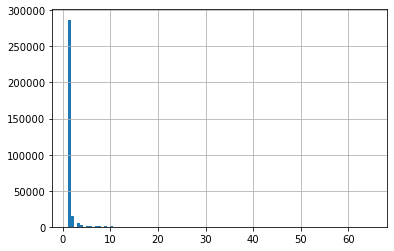

In [44]:
row_count.hist(bins = 100)

In [45]:
# packedQuantity가 0인 경우의 행 갯수 기초통계량

row_count.describe()

count    316242.000000
mean          1.318588
std           1.748768
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          65.000000
dtype: float64

In [46]:
row_count[row_count > 10]

orderProductId
2987756     25
3013409     15
3055870     11
3094295     27
3106406     17
            ..
15841447    14
15846767    12
15846769    12
15853002    11
15856511    11
Length: 2526, dtype: int64

In [47]:
row_count[row_count > 60]

orderProductId
8270580     64
11232213    65
14227126    62
dtype: int64

In [90]:
np.min(dataframe['createdAt'])

Timestamp('2018-07-09 06:32:24.824675+0000', tz='UTC')

In [135]:
np.max(dataframe['createdAt'])

Timestamp('2021-11-21 05:53:13.780939+0000', tz='UTC')

In [93]:
dataframe[dataframe['orderProductId'] == 2987756]

id  orderProductId  orderProductExtraId  sellerPermitWaitShipment  \
140      31596         2987756                  NaN                     False   
229      33669         2987756                  NaN                     False   
1779     35632         2987756                  NaN                     False   
3656     41503         2987756                  NaN                     False   
4701     43714         2987756                  NaN                     False   
8252     36959         2987756                  NaN                     False   
11141    40015         2987756                  NaN                     False   
2632982  10904         2987756                  NaN                     False   
2633899  11723         2987756                  NaN                     False   
2635073  13032         2987756                  NaN                     False   
2636498  16507         2987756                  NaN                     False   
2637187  22272         2987756                  NaN                     False   
2640262  21096         2987756                  NaN                     False   
2640436  17276         2987756                  NaN                     False   
2642374  19739         2987756                  NaN                     False   
2644697  18612         2987756                  NaN                     False   
2645171  22916         2987756                  NaN                     False   
2645586  26439         2987756                  NaN                     False   
2646846  23816         2987756                  NaN                     False   
2647822  29423         2987756                  NaN                     False   
2648616  27917         2987756                  NaN                     False   
2650010  27068         2987756                  NaN                     False   
2650512  24524         2987756                  NaN                     False   
2651507  28689         2987756                  NaN                     False   
2654363  32218         2987756                  NaN                     False   

         packedQuantity  discontinued                  arriveAt sellerMemo  \
140                   0         False 2018-09-06 00:00:00+00:00       None   
229                   0         False 2018-09-07 00:00:00+00:00       None   
1779                  0         False 2018-09-08 00:00:00+00:00       None   
3656                  0         False 2018-09-13 00:00:00+00:00       None   
4701                  0         False                       NaT       None   
8252                  0         False 2018-09-11 00:00:00+00:00       None   
11141                 0         False 2018-09-13 00:00:00+00:00       None   
2632982               0         False 2018-08-02 00:00:00+00:00       None   
2633899               0         False 2018-08-11 00:00:00+00:00       None   
2635073               0         False                       NaT       None   
2636498               0         False 2018-08-16 00:00:00+00:00       None   
2637187               0         False 2018-08-23 00:00:00+00:00       None   
2640262               0         False 2018-08-21 00:00:00+00:00       None   
2640436               0         False 2018-08-20 00:00:00+00:00       None   
2642374               0         False 2018-08-21 00:00:00+00:00       None   
2644697               0         False 2018-08-18 00:00:00+00:00       None   
2645171               0         False 2018-08-24 00:00:00+00:00       None   
2645586               0         False 2018-08-31 00:00:00+00:00       None   
2646846               0         False 2018-08-25 00:00:00+00:00       None   
2647822               0         False 2018-09-04 00:00:00+00:00       None   
2648616               0         False 2018-08-31 00:00:00+00:00       None   
2650010               0         False 2018-08-30 09:00:00+00:00       None   
2650512               0         False 2018-08-27 00:00:00+00:00       None   
2651507               0         F

In [82]:
np.max(dataframe[dataframe['orderProductId'] == 8270580]['updatedAt'])

Timestamp('2019-12-26 20:23:48.679978+0000', tz='UTC')

In [50]:
dataframe[dataframe['orderProductId'] == 15841447]

id  orderProductId  orderProductExtraId  \
2580016  2613827        15841447                  NaN   
2581620  2616733        15841447                  NaN   
2586121  2620077        15841447                  NaN   
2590503  2621171        15841447                  NaN   
2593826  2627123        15841447                  NaN   
2597068  2630839        15841447                  NaN   
2598742  2634427        15841447                  NaN   
2604142  2637358        15841447                  NaN   
2605108  2639513        15841447                  NaN   
2610515  2646161        15841447                  NaN   
2615121  2649273        15841447                  NaN   
2618112  2651516        15841447                  NaN   
2620541  2654453        15841447                  NaN   
2621007  2655311        15841447                  NaN   

         sellerPermitWaitShipment  packedQuantity  discontinued arriveAt  \
2580016                      True               0         False      NaT   
2581620                      True               0         False      NaT   
2586121                      True               0         False      NaT   
2590503                      True               0         False      NaT   
2593826                      True               0         False      NaT   
2597068                      True               0         False      NaT   
2598742                      True               0         False      NaT   
2604142                      True               0         False      NaT   
2605108                      True               0         False      NaT   
2610515                      True               0         False      NaT   
2615121                      True               0         False      NaT   
2618112                      True               0         False      NaT   
2620541                      True               0         False      NaT   
2621007                      True               0         False      NaT   

         sellerMemo  status                        createdAt  \
2580016  다음주월화밤예정요        0 2021-11-02 15:47:23.233184+00:00   
2581620        None       0 2021-11-03 15:23:32.503328+00:00   
2586121        None       0 2021-11-04 16:11:08.621901+00:00   
2590503        None       0 2021-11-05 17:50:39.705650+00:00   
2593826        None       0 2021-11-08 14:59:01.774720+00:00   
2597068        None       0 2021-11-09 15:43:15.318430+00:00   
2598742        None       0 2021-11-10 17:30:49.471181+00:00   
2604142        None       0 2021-11-11 14:56:58.555543+00:00   
2605108        None       0 2021-11-12 15:11:31.870076+00:00   
2610515        None       0 2021-11-15 16:31:04.891367+00:00   
2615121        None       0 2021-11-16 16:52:25.204307+00:00   
2618112        None       0 2021-11-17 14:58:46.604485+00:00   
2620541        None       0 2021-11-18 15:30:30.640025+00:00   
2621007        None     100 2021-11-19 14:58:21.184732+00:00   

                               updatedAt  sellerId  
2580016 2021-11-02 21:18:11.587232+00:00     11927  
2581620 2021-11-03 21:11:28.612957+00:00     11927  
2586121 2021-11-04 21:13:43.262092+00:00     11927  
2590503 2021-11-07 21:01:35.123580+00:00     11927  
2593826 2021-11-08 21:09:28.882545+00:00     11927  
2597068 2021-11-09 21:13:36.995998+00:00     11927  
2598742 2021-11-10 21:15:15.455485+00:00     11927  
2604142 2021-11-11 21:38:24.805996+00:00     11927  
2605108 2021-11-14 21:31:49.832999+00:00     11927  
2610515 2021-11-15 21:11:05.838959+00:00     11927  
2615121 2021-11-16 21:18:46.673194+00:00     11927  
2618112 2021-11-17 21:29:36.109559+00:00     11927  
2620541 2021-11-18 21:20:15.326672+00:00     11927  
2621007 2021-11-19 19:08:37.677013+00:00     11927

두달에 걸쳐 장기 미송된 경우도 있고, 비교적 단기간에 집중적으로 재송 요청이 발생한 경우도 있다.

#### 결론 : packedQuantity가 0인 경우, 이를 orderProductId로 묶어서 살펴봤을 때 절대 다수가 행 한개짜리 데이터이다.

#### 두 개 이상인 경우가 흥미로운데, 집중적으로 관리가 필요한 장기 미송 사례 / 클레임 발생 우려 사례로 볼 수 있다.

## 2) orderProductId 기반 분석

### (1) orderProduct 중복 사례 분석

### - 가설 2 : orderProductId가 중복된 경우는 재발송 사례이다. 

In [51]:
dataframe.shape[0]

2655438

In [52]:
len(dataframe['orderProductId'].unique())

2180328

In [53]:
len(dataframe['orderProductId'].unique()) / dataframe.shape[0] * 100

82.10803641433164

전체 사례중 82%는 orderProductId가 중복되지 않은 사례이다.(즉 Unique하다.)

전체 샘플 중 18%는 orderProductId가 중복된 사례이다.

미송 등이 발생했을경우 동일 orderProductId가 반복해서 생산되었다는 가정 하에 분석을 진행한다.

<AxesSubplot:>

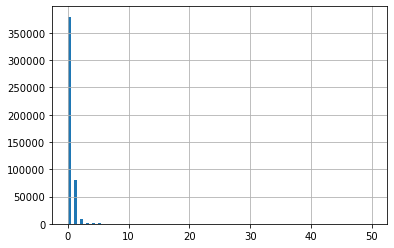

In [54]:
dataframe[dataframe['orderProductId'].duplicated(keep='last')]['packedQuantity'].hist(bins = 100, range = (0,50))

#### 소결론 : orderProductId가 중복된것은 packedQuantity가 모두 0인줄 알았는데, 의외로 1 이상인 값들도 많이 보인다

#### 확인이 필요하다.

In [55]:
temp = dataframe[dataframe['orderProductId'].duplicated(keep='last')]

In [56]:
# id_list는 orderProductId가 중복된 사례 중 packedQuantity가 0인 사례들의 orderProductId이다.

id_list = temp[temp['packedQuantity'] < 1]['orderProductId'].unique()

In [57]:
dataframe[dataframe['orderProductId'] == id_list[1]]

id  orderProductId  orderProductExtraId  sellerPermitWaitShipment  \
7      51090         3454813                  NaN                     False   
15436  53215         3454813                  NaN                     False   
16221  56503         3454813                  NaN                     False   
16467  55283         3454813                  NaN                     False   
29063  60485         3454813                  NaN                     False   

       packedQuantity  discontinued arriveAt sellerMemo  status  \
7                   0         False      NaT       None       0   
15436               0         False      NaT       None       0   
16221               0         False      NaT       None       0   
16467               1         False      NaT       None       0   
29063               0          True      NaT       None       0   

                             createdAt                        updatedAt  \
7     2018-09-17 17:02:06.428185+00:00 2018-09-17 23:56:30.551538+00:00   
15436 2018-09-18 16:35:26.007815+00:00 2018-09-18 22:48:29.208708+00:00   
16221 2018-09-20 16:17:01.424196+00:00 2018-09-20 23:04:49.005498+00:00   
16467 2018-09-19 17:30:07.985924+00:00 2018-09-19 21:39:28.870723+00:00   
29063 2018-09-27 18:09:16.620335+00:00 2018-09-28 01:27:51.442421+00:00   

       sellerId  
7         25524  
15436     25524  
16221     25524  
16467     25524  
29063     25524

In [59]:
dataframe[dataframe['orderProductId'] == id_list[2]]

id  orderProductId  orderProductExtraId  sellerPermitWaitShipment  \
20    31227         3275700                  NaN                     False   
5306  37443         3275700                  NaN                      True   

      packedQuantity  discontinued arriveAt sellerMemo  status  \
20                 0         False      NaT     리오더중\n       0   
5306               1         False      NaT       None       0   

                            createdAt                        updatedAt  \
20   2018-09-03 14:30:44.098949+00:00 2018-09-03 22:21:09.729904+00:00   
5306 2018-09-09 13:17:34.088086+00:00 2018-09-09 23:20:23.755972+00:00   

      sellerId  
20       11765  
5306     11765

In [60]:
def num_gen():
    i = 0
    while True:
        i += 1
        yield i

In [61]:
gen = num_gen()

In [62]:
def len_counter(x):
    iters = next(gen)
    if iters % 1000 == 0:
        print(iters)
    return x.shape[0]

In [660]:
row_count = pd.merge(pd.Series(id_list, name = 'orderProductId'), dataframe,
         how = 'left').groupby('orderProductId').apply(lambda x : len_counter(x))

149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
159000
160000
161000
162000
163000
164000
165000
166000
167000
168000
169000
170000
171000
172000
173000
174000
175000
176000
177000
178000
179000
180000
181000
182000
183000
184000
185000
186000
187000
188000
189000
190000
191000
192000
193000
194000
195000
196000
197000
198000
199000
200000
201000
202000
203000
204000
205000
206000
207000
208000
209000
210000
211000
212000
213000
214000
215000
216000
217000
218000
219000
220000
221000
222000
223000
224000
225000
226000
227000
228000
229000
230000
231000
232000
233000
234000
235000
236000
237000
238000
239000
240000
241000
242000
243000
244000
245000
246000
247000
248000
249000
250000
251000
252000
253000
254000
255000
256000
257000
258000
259000
260000
261000
262000
263000
264000
265000
266000
267000
268000
269000
270000
271000
272000
273000
274000
275000
276000
277000
278000
279000
280000
281000
282000
283000
284000
285000
286000
287000
288000
289000
290000
291000

<AxesSubplot:>

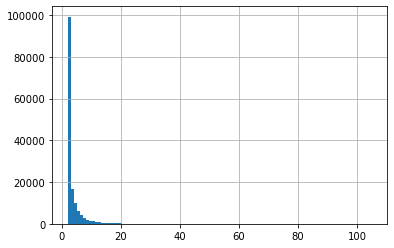

In [661]:
row_count.hist(bins = 100)

In [662]:
row_count.describe()

count    148359.000000
mean          3.782049
std           3.199709
min           2.000000
25%           2.000000
50%           3.000000
75%           4.000000
max         105.000000
dtype: float64

In [668]:
row_count[row_count > 4 + 1.5 * (4 - 2)]

orderProductId
2871044     10
2896446      8
2915199     10
2933938      8
2943092      8
            ..
15899868     8
15900582     8
15901339     8
15913159     8
15913160     8
Length: 12231, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x1cf5d927790>,
 'caps': [<matplotlib.lines.Line2D at 0x1cf5d927eb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1cf5d91b220>],
 'medians': [<matplotlib.lines.Line2D at 0x1cf5d92d610>],
 'fliers': [<matplotlib.lines.Line2D at 0x1cf5d92d9a0>],
 'means': []}

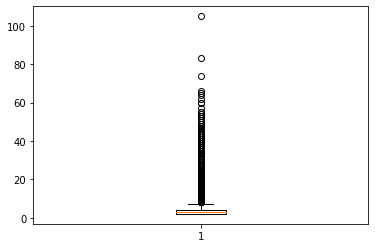

In [663]:
plt.boxplot(row_count)

In [63]:
id_list = temp[temp['packedQuantity'] > 0]['orderProductId'].unique()

In [64]:
gen = num_gen()

In [65]:
row_count = pd.merge(pd.Series(id_list, name = 'orderProductId'), dataframe,
         how = 'left').groupby('orderProductId').apply(lambda x : len_counter(x))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000


<AxesSubplot:>

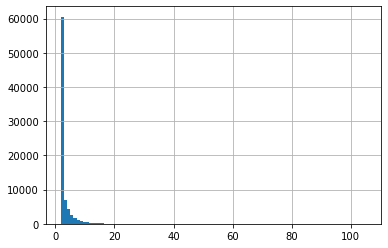

In [66]:
row_count.hist(bins = 100)

In [67]:
row_count.describe()

count    80556.000000
mean         3.272332
std          2.596100
min          2.000000
25%          2.000000
50%          2.000000
75%          3.000000
max        105.000000
dtype: float64

In [68]:
row_count[row_count > 4 + 1.5 * (3- 2)]

orderProductId
2809642      7
2821870      6
2915199     10
2920599      7
2933938      8
            ..
15919450     6
15919453     6
15927073     6
15927972     7
15934355     6
Length: 8765, dtype: int64

In [72]:
packed_over_1 = pd.merge(pd.Series(id_list, name = 'orderProductId'), dataframe,
         how = 'left')

In [76]:
packed_over_1

orderProductId     id  orderProductExtraId  sellerPermitWaitShipment  \
0              3217294  33592                  NaN                     False   
1              3217294  35213                  NaN                     False   
2              3217294  32079                  NaN                     False   
3              3318398  35244                  NaN                      True   
4              3318398  34872                  NaN                     False   
...                ...    ...                  ...                       ...   
263601         3278743  37038                  NaN                     False   
263602         3278743  40054                  NaN                     False   
263603         3278743  32227                  NaN                     False   
263604         3267437  33178                  NaN                      True   
263605         3267437  31574                  NaN                     False   

        packedQuantity  discontinued                  arriveAt    sellerMemo  \
0                    1         False                       NaT          None   
1                    1         False                       NaT          None   
2                    1         False                       NaT          None   
3                   30         False                       NaT          None   
4                   30         False                       NaT          None   
...                ...           ...                       ...           ...   
263601               0         False 2018-09-11 00:00:00+00:00          None   
263602               1         False                       NaT          None   
263603               0         False 2018-09-10 00:00:00+00:00  전부 금밤이나 월밤입고   
263604               1         False                       NaT          None   
263605               1         False                       NaT          None   

        status                        createdAt  \
0            0 2018-09-05 00:07:21.824921+00:00   
1            0 2018-09-05 23:36:02.970832+00:00   
2            0 2018-09-03 22:27:14.211293+00:00   
3            0 2018-09-06 01:57:28.965393+00:00   
4            0 2018-09-05 16:28:20.699267+00:00   
...        ...                              ...   
263601       0 2018-09-09 11:07:53.477080+00:00   
263602       0 2018-09-10 15:04:47.848002+00:00   
263603       0 2018-09-04 11:15:05.809077+00:00   
263604       0 2018-09-04 15:45:36.437355+00:00   
263605       0 2018-09-03 15:34:52.993272+00:00   

                              updatedAt  sellerId  
0      2018-09-05 22:18:43.222725+00:00      6022  
1      2018-09-06 22:57:07.720362+00:00      6022  
2      2018-09-04 22:05:53.982383+00:00      6022  
3      2018-09-06 21:21:43.063133+00:00     18447  
4      2018-09-05 21:52:41.179530+00:00     18447  
...                                 ...       ...  
263601 2018-09-09 23:20:23.755972+00:00     19926  
263602 2018-09-10 23:37:17.393414+00:00     19926  
263603 2018-09-04 22:05:53.982383+00:00     19926  
263604 2018-09-04 22:05:53.982383+00:00      8532  
263605 2018-09-03 22:21:09.729904+00:00      8532  

[263606 rows x 12 columns]

In [79]:
packed_over_1[packed_over_1['orderProductId'] == 3318398]

orderProductId     id  orderProductExtraId  sellerPermitWaitShipment  \
3         3318398  35244                  NaN                      True   
4         3318398  34872                  NaN                     False   

   packedQuantity  discontinued arriveAt sellerMemo  status  \
3              30         False      NaT       None       0   
4              30         False      NaT       None       0   

                         createdAt                        updatedAt  sellerId  
3 2018-09-06 01:57:28.965393+00:00 2018-09-06 21:21:43.063133+00:00     18447  
4 2018-09-05 16:28:20.699267+00:00 2018-09-05 21:52:41.179530+00:00     18447

In [ ]:
packed_over_1[packed_over_1['orderProductId'] == 3217294]

#### 소결론 : orderProductId가 중복되는 사례는 미송이 발생하여 해당 주문번호 사입을 n번 다시 시도한 경우로 볼 수 있다.
#### 이 때, packedQuantity가 0으로 끝나는 경우, 1 이상으로 끝나는 경우가 있는데, 각각의 경우 확인이 필요하다.

### - 장기 미송이 해결된 기간

In [338]:
datelist = list()

for num, i in enumerate(id_list):
    temp = dataframe[dataframe['orderProductId'] == i].tail(1)
    datelist.append(temp['createdAt'] - temp['updatedAt'])
    if num%1000 == 0:
        print(num / len(id_list))

0.0
0.012423903590508137
0.024847807181016274
0.03727171077152441
0.04969561436203255
0.06211951795254069
0.07454342154304883
0.08696732513355697
0.0993912287240651
0.11181513231457324
0.12423903590508138
0.13666293949558952
0.14908684308609765
0.16151074667660578
0.17393465026711394
0.18635855385762207
0.1987824574481302
0.21120636103863835
0.22363026462914648
0.2360541682196546
0.24847807181016277
0.2609019754006709
0.27332587899117905
0.28574978258168715
0.2981736861721953
0.31059758976270346
0.32302149335321156
0.3354453969437197
0.3478693005342279
0.360293204124736
0.37271710771524413
0.3851410113057523
0.3975649148962604
0.40998881848676855
0.4224127220772767
0.4348366256677848
0.44726052925829296
0.4596844328488011
0.4721083364393092
0.4845322400298174
0.49695614362032553
0.5093800472108336
0.5218039508013418
0.5342278543918499
0.5466517579823581
0.5590756615728661
0.5714995651633743
0.5839234687538825
0.5963473723443906
0.6087712759348988
0.6211951795254069
0.633619083115915
0.

In [342]:
datelist_2 = [-int(i.dt.days) for i in pd.Series(datelist)]

<AxesSubplot:>

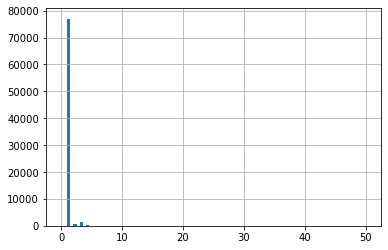

In [349]:
pd.Series(datelist_2).hist(bins = 100, range = (0,50))

In [361]:
id_list = pd.concat([pd.Series(id_list),
           pd.Series(datelist_2)], axis = 1)

In [382]:
dataframe[dataframe['orderProductId'] == id_list[id_list[1] < 2][0].to_numpy()[0]]

id  orderProductId  orderProductExtraId  \
424      1337443        10625042                  NaN   
1170546  1343377        10625042                  NaN   

         sellerPermitWaitShipment  packedQuantity  discontinued arriveAt  \
424                         False               1         False      NaT   
1170546                      True               1         False      NaT   

        sellerMemo  status                        createdAt  \
424           None       0 2020-03-31 13:57:12.358739+00:00   
1170546       None       0 2020-04-02 12:26:23.377916+00:00   

                               updatedAt  sellerId  
424     2020-03-31 20:31:42.691235+00:00     99959  
1170546 2020-04-02 20:18:03.687083+00:00     99959

In [384]:
dataframe[dataframe['orderProductId'] == id_list[id_list[1] < 2][0].to_numpy()[100]]

id  orderProductId  orderProductExtraId  \
2514     1477329        11250938                  NaN   
1576019  1470568        11250938                  NaN   

         sellerPermitWaitShipment  packedQuantity  discontinued arriveAt  \
2514                         True               2         False      NaT   
1576019                     False               2         False      NaT   

        sellerMemo  status                        createdAt  \
2514          None       0 2020-05-22 13:04:36.898465+00:00   
1576019       None       0 2020-05-20 14:15:44.625616+00:00   

                               updatedAt  sellerId  
2514    2020-05-24 20:51:31.194982+00:00     62864  
1576019 2020-05-20 20:43:51.509351+00:00     62864

위 두 사례는 특정이 불가능하다.

In [383]:
dataframe[dataframe['orderProductId'] == id_list[id_list[1] < 2][0].to_numpy()[1]]

id  orderProductId  orderProductExtraId  \
548      1477295        11279941                  NaN   
1075011  1477427        11279941                  NaN   
1322095  1483497        11279941                  NaN   

         sellerPermitWaitShipment  packedQuantity  discontinued arriveAt  \
548                         False               1         False      NaT   
1075011                      True               1         False      NaT   
1322095                      True               1         False      NaT   

        sellerMemo  status                        createdAt  \
548           None       0 2020-05-21 20:52:07.014990+00:00   
1075011       None       0 2020-05-22 16:04:48.575255+00:00   
1322095       None       0 2020-05-25 11:56:31.078660+00:00   

                               updatedAt  sellerId  
548     2020-05-22 00:01:14.009627+00:00     41091  
1075011 2020-05-24 20:51:31.194982+00:00     41091  
1322095 2020-05-25 20:47:31.205408+00:00     41091

In [385]:
dataframe[dataframe['orderProductId'] == id_list[id_list[1] < 2][0].to_numpy()[2321]]

id  orderProductId  orderProductExtraId  sellerPermitWaitShipment  \
60562  59776         3549830                  NaN                     False   
70822  67235         3549830                  NaN                      True   
72228  63116         3549830                  NaN                      True   

       packedQuantity  discontinued                  arriveAt sellerMemo  \
60562               0         False 2018-09-28 15:00:00+00:00              
70822               1         False                       NaT       None   
72228               0         False 2018-10-01 15:00:00+00:00              

       status                        createdAt  \
60562       0 2018-09-27 15:32:43.460500+00:00   
70822       0 2018-10-03 14:21:54.425081+00:00   
72228       0 2018-09-30 15:17:29.930187+00:00   

                             updatedAt  sellerId  
60562 2018-09-28 01:27:51.442421+00:00     40965  
70822 2018-10-03 23:07:17.275006+00:00     40965  
72228 2018-09-30 23:46:08.778423+00:00     40965

위 두 사례는 인덱싱이 꼬인 사례로 보인다(시간 흐름상)

In [389]:
dataframe[dataframe['packedQuantity'] < 1]

id  orderProductId  orderProductExtraId  \
5             55         2744054                  NaN   
6             92         2740425                  NaN   
8             67         2734183                  NaN   
17       2010061        13464235                  NaN   
42       1336216        10611460                  NaN   
...          ...             ...                  ...   
2655419  2655432        15996476                  NaN   
2655420  2655433        15996477                  NaN   
2655421  2655434        15996478                  NaN   
2655422  2655435        15996479                  NaN   
2655433  2655446        15918660                  NaN   

         sellerPermitWaitShipment  packedQuantity  discontinued  \
5                           False               0         False   
6                           False               0         False   
8                           False               0         False   
17                           True               0         False   
42                          False               0         False   
...                           ...             ...           ...   
2655419                     False               0          True   
2655420                     False               0         False   
2655421                     False               0         False   
2655422                     False               0         False   
2655433                     False               0         False   

                         arriveAt   sellerMemo  status  \
5                             NaT         None       0   
6                             NaT        깔품절이요       0   
8       2018-07-11 15:00:00+00:00                    0   
17                            NaT         None       0   
42      2020-03-31 15:00:00+00:00         내일이요       0   
...                           ...          ...     ...   
2655419                       NaT                  100   
2655420                       NaT  미송으로 가능하세여      100   
2655421 2021-11-21 15:00:00+00:00                  100   
2655422 2021-11-21 15:00:00+00:00                  100   
2655433                       NaT                  100   

                               createdAt                        updatedAt  \
5       2018-07-09 14:50:41.602259+00:00 2018-07-10 00:48:44.560994+00:00   
6       2018-07-09 15:02:14.228352+00:00 2018-07-10 00:48:44.560994+00:00   
8       2018-07-09 14:53:17.874404+00:00 2018-07-10 00:48:44.560994+00:00   
17      2021-01-14 20:54:15.992510+00:00 2021-01-15 00:01:02.943993+00:00   
42      2020-03-30 20:55:35.389196+00:00 2020-03-31 00:01:11.411699+00:00   
...                                  ...                              ...   
2655419 2021-11-21 00:02:12.038630+00:00 2021-11-21 00:02:12.038630+00:00   
2655420 2021-11-21 00:02:12.038630+00:00 2021-11-21 00:02:12.038630+00:00   
2655421 2021-11-21 00:02:12.038630+00:00 2021-11-21 00:02:12.038630+00:00   
2655422 2021-11-21 00:02:12.038630+00:00 2021-11-21 00:02:12.038630+00:00   
2655433 2021-11-21 04:43:43.779109+00:00 2021-11-21 04:43:43.779109+00:00   

         sellerId  
5             473  
6            5400  
8           40814  
17          67961  
42          17566  
...           ...  
2655419    120446  
2655420    120446  
2655421    120446  
2655422    120446  
2655433     70198  

[726091 rows x 12 columns]

이상한 사례이다. 마지막 로그는 2018-07-23에 남겨졌는데, 업데이트는 그로부터 2년 뒤인 2020년에 갱신되었다.

In [148]:
dataframe[dataframe['orderProductExtraId'].isna()].apply(lambda x : x.isna().value_counts())

id  orderProductId  orderProductExtraId  \
False  2620739.0       2620739.0                  NaN   
True         NaN             NaN            2620739.0   

       sellerPermitWaitShipment  packedQuantity  discontinued  arriveAt  \
False                 2620739.0       2620739.0     2620739.0    256164   
True                        NaN             NaN           NaN   2364575   

       sellerMemo     status  createdAt  updatedAt   sellerId  
False      344715  2620739.0  2620739.0  2620739.0  2620739.0  
True      2276024        NaN        NaN        NaN        NaN

In [147]:
dataframe[~dataframe['orderProductExtraId'].isna()].apply(lambda x : x.isna().value_counts())

id  orderProductId  orderProductExtraId  sellerPermitWaitShipment  \
False  34699.0         34699.0              34699.0                   34699.0   
True       NaN             NaN                  NaN                       NaN   

       packedQuantity  discontinued  arriveAt  sellerMemo   status  createdAt  \
False         34699.0       34699.0      1799        4421  34699.0    34699.0   
True              NaN           NaN     32900       30278      NaN        NaN   

       updatedAt  sellerId  
False    34699.0   34699.0  
True         NaN       NaN

In [143]:
dataframe[dataframe['orderProductExtraId'].isna()][dataframe[dataframe['orderProductExtraId'].isna()]['packedQuantity'] > 1]

id  orderProductId  orderProductExtraId  \
7             60         2738293                  NaN   
11          1074         2771189                  NaN   
12          1078         2771193                  NaN   
13          1060         2771027                  NaN   
14          1152         2773598                  NaN   
...          ...             ...                  ...   
2655410  2655325        15995998                  NaN   
2655411  2655324        15995997                  NaN   
2655412  2655323        15995996                  NaN   
2655425  2655438        15996741                  NaN   
2655437  2655450        16001381                  NaN   

         sellerPermitWaitShipment  packedQuantity  discontinued arriveAt  \
7                           False               2         False      NaT   
11                          False               2         False      NaT   
12                          False               4         False      NaT   
13                          False               2         False      NaT   
14                          False               3         False      NaT   
...                           ...             ...           ...      ...   
2655410                     False               5         False      NaT   
2655411                     False               4         False      NaT   
2655412                     False               6         False      NaT   
2655425                     False               2         False      NaT   
2655437                     False               2         False      NaT   

        sellerMemo  status                        createdAt  \
7             None       0 2018-07-09 14:51:16.999109+00:00   
11            None       0 2018-07-11 15:31:45.309076+00:00   
12            None       0 2018-07-11 15:31:45.309076+00:00   
13            None       0 2018-07-11 15:24:08.640385+00:00   
14            None       0 2018-07-11 15:52:48.015283+00:00   
...            ...     ...                              ...   
2655410       None       0 2021-11-19 15:06:35.859035+00:00   
2655411       None       0 2021-11-19 15:06:35.859035+00:00   
2655412       None       0 2021-11-19 15:06:35.859035+00:00   
2655425       None     100 2021-11-21 00:15:44.845821+00:00   
2655437       None     100 2021-11-21 05:53:13.780939+00:00   

                               updatedAt  sellerId  
7       2018-07-10 00:48:44.560994+00:00     21744  
11      2018-07-11 21:49:58.656118+00:00      5623  
12      2018-07-11 21:49:58.656118+00:00      5623  
13      2018-07-11 21:49:58.656118+00:00      6759  
14      2018-07-11 21:51:12.786334+00:00     10314  
...                                  ...       ...  
2655410 2021-11-19 17:49:17.180219+00:00     35278  
2655411 2021-11-19 17:49:17.180219+00:00     35278  
2655412 2021-11-19 17:49:17.180219+00:00     35278  
2655425 2021-11-21 00:15:44.845821+00:00    121642  
2655437 2021-11-21 05:53:13.780939+00:00    133814  

[403681 rows x 12 columns]

In [129]:
dataframe['sellerPermitWaitShipment'].value_counts()

False    2379550
True      275888
Name: sellerPermitWaitShipment, dtype: int64

In [126]:
dataframe.describe()

id  orderProductId  orderProductExtraId  packedQuantity  \
count  2.655438e+06    2.655438e+06         34699.000000    2.655438e+06   
mean   1.327727e+06    1.028645e+07        424717.215338    2.696125e+00   
std    7.665630e+05    3.574780e+06        163553.435488    2.215582e+02   
min    1.000000e+00    2.229655e+06         62986.000000    0.000000e+00   
25%    6.638632e+05    7.421890e+06        302910.000000    0.000000e+00   
50%    1.327732e+06    1.056011e+07        450021.000000    1.000000e+00   
75%    1.991591e+06    1.339599e+07        558145.500000    1.000000e+00   
max    2.655450e+06    1.600138e+07        695523.000000    7.900000e+04   

             status      sellerId  
count  2.655438e+06  2.655438e+06  
mean   3.389271e-03  4.947202e+04  
std    5.821647e-01  3.324318e+04  
min    0.000000e+00  3.000000e+00  
25%    0.000000e+00  2.257000e+04  
50%    0.000000e+00  4.540800e+04  
75%    0.000000e+00  6.997600e+04  
max    1.000000e+02  1.478260e+05

장기 미송이 해결된 기간은 추가 분석이 필요하다.

# 3) wait_shipment_logs와 교차 분석

### (1) orderProductId 미일치 사례 조사

wait_shipmen_logs는 '미송 이력 테이블'로 설명이 되어있다.

그러면 seller_packing_info의 미송 내역과 wait_shipment_logs의 미송 이력이 일치해야하나, 일치하지 않고 일부 누락된 사례가 발견된다.

#### - 가설 4 : orderProductId가 누락된 사례는 wait_shipment_logs보단 seller_packing_info에서 집중적으로 발견될것이다.

In [33]:
temp = dataframe[dataframe['orderProductId'].duplicated(keep='last')]

In [64]:
len(temp['orderProductId'].unique())

200718

In [65]:
len(dataframe_2['orderProductId'].unique())

6199435

In [70]:
len(dataframe_2['orderProductId'].unique())

6199435

In [82]:
list(set(dataframe_2['orderProductId'].unique()).intersection(temp['orderProductId'].unique()))[0:10]

[7864323,
 13107212,
 13107213,
 13107214,
 13107215,
 13107216,
 13107217,
 13107218,
 13107219,
 13107220]

In [87]:
dataframe_2[dataframe_2['orderProductId'] == 7864323]

id  buyerId  brandId  orderId  orderProductId  quantity  \
3724059  4908496    21855      287   468304         7864323         1   
3739573  4912460    21855      287   468304         7864323         1   
3741623  4923713    21855      287   468304         7864323         1   

         finalQuantity  userQuantity                  arriveAt  provider  ...  \
3724059              0             0 2019-08-29 00:00:00+00:00       0.0  ...   
3739573              0             0 2019-08-29 00:00:00+00:00       0.0  ...   
3741623              1             0                       NaT       0.0  ...   

        status  waitShipmentType waitShipmentQuantity  \
3724059  501.0             100.0                  1.0   
3739573  501.0             100.0                  1.0   
3741623  400.0             100.0                  1.0   

        waitShipmentPickupQuantity isLatest pickupQuantity  creatorId  \
3724059                        NaN        N            0.0      122.0   
3739573                        0.0        N            0.0      122.0   
3741623                        1.0        Y            1.0    34619.0   

                  startOfArriveAt             endOfArriveAt  data  
3724059 2019-08-29 00:00:00+00:00 2019-09-03 00:00:00+00:00  None  
3739573 2019-08-29 00:00:00+00:00 2019-09-03 00:00:00+00:00  None  
3741623                       NaT                       NaT  None  

[3 rows x 26 columns]

In [88]:
temp[temp['orderProductId'] == 7864323]

id  orderProductId  orderProductExtraId  sellerPermitWaitShipment  \
377164  742113         7864323                  NaN                      True   

        packedQuantity  discontinued                  arriveAt sellerMemo  \
377164               0         False 2019-08-27 15:00:00+00:00         내일   

        status                        createdAt  \
377164       0 2019-08-27 14:20:50.528843+00:00   

                              updatedAt  sellerId  
377164 2019-08-27 20:30:28.538512+00:00     34619

In [89]:
print(set(temp['orderProductId'].unique()).difference(dataframe_2['orderProductId'].unique()))
print('seller_packing이 고유한 갯수 : ',len(set(temp['orderProductId'].unique()).difference(dataframe_2['orderProductId'].unique())))

{4019221, 4050998, 3311835}
seller_packing이 고유한 갯수 :  3


이 orderProductId는 seller_packing에는 존재하나 wait_shipment에는 존재하지 않는다

In [46]:
#print(set(dataframe_2['orderProductId'].unique()).difference(temp['orderProductId'].unique()))
print('wait_shipment에서 고유한 갯수 : ',len(set(dataframe_2['orderProductId'].unique()).difference(temp['orderProductId'].unique())))

wait_shipment에서 고유한 갯수 :  5998720


In [44]:
print('양측 모두에 존재하는 갯수 : ',len(set(dataframe_2['orderProductId'].unique()).intersection(temp['orderProductId'].unique())))

양측 모두에 존재하는 갯수 :  200715


#### 소결론 : 예상대로,  orderProductId가 누락된 예는 wait_shipment 보단 주로 tb_seller_packing쪽에서 발생하였다. 

#### 양 쪽 모두의 사례를 심층적으로 탐색해서 일치하지 않는 이유를 확인해야한다.

In [47]:
merge_table_2 = pd.merge(pd.Series(list(set(dataframe_2['orderProductId'].unique()).difference(temp['orderProductId'].unique())),
                           name = 'orderProductId'), dataframe_2)

In [48]:
# wait_shipment엔 있으나 seller_packing엔 없는 productOrderId의 월간 생산량

(merge_table_2['createdAt'].dt.year.astype('str') + '-' + merge_table_2['createdAt'].dt.month.astype('str')).value_counts()

2019-11    337237
2019-7     328585
2019-5     316927
2019-10    314334
2019-6     305199
2019-4     304258
2019-3     302885
2019-9     277337
2019-12    263746
2018-12    236738
2019-8     233655
2018-10    232940
2018-11    227596
2019-1     224906
2018-7     216418
2018-9     215452
2020-6     213109
2020-5     202127
2021-3     179900
2019-2     177264
2020-3     172903
2018-8     167856
2020-4     163441
2020-7     158193
2021-4     152990
2020-11    149190
2020-10    147561
2020-2     146792
2020-1     139794
2021-6     120830
2021-10    117249
2020-9     117132
2021-5     114720
2020-12    113129
2021-7     103258
2021-9      99727
2021-1      97575
2021-2      92190
2021-11     87818
2020-8      86572
2021-8      66882
Name: createdAt, dtype: int64

### -가설 5 : 불일치 사례는 삼촌이 입력을 안했으나 주문은 진행된 건, 즉 빅 바이어의 주문에서 주로 발생할 것이다.

In [52]:
init_quantity = merge_table_2.groupby('buyerId')["quantity"].apply(lambda x : x.iloc[0])

In [53]:
init_quantity.hist(bins = 100)

<AxesSubplot:>

최초 주문량으로는 빅바이어인지 아닌지 알수가 없다.

In [54]:
merge_table_2['createdAt_date'] = merge_table_2['createdAt'].dt.date

In [55]:
buyer_buy_per_date = merge_table_2.groupby(['buyerId', 'createdAt_date'])['quantity'].sum()

<AxesSubplot:>

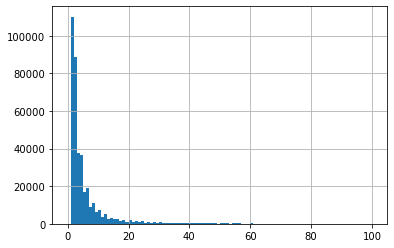

In [95]:
buyer_buy_per_date.hist(bins = 100, range = (0,100))

In [57]:
buyer_buy_per_date.reset_index().groupby('buyerId')['quantity'].mean().hist(bins = 100, range = (0,100))

<AxesSubplot:>

각 일별로, 바이어들을 묶어 히스토그램을 그려봐도 대부분의 바이어들의 일간 거래는 1 ~ 10개 사이에 몰려있다.

이정도면, 빅바이어라고 할 수는 없다.

In [58]:
dataframe_3['type'].value_counts()

100    119564
200      4600
0        1084
Name: type, dtype: int64

#### - 전체 / wait_shipment에만 존재하는 orderProductId의 바이어 유형 빈도에 대한 가설검정

##### H0 : 두 분포의 기대빈도는 예상 가능한 범위 내에 있다.(두 분포는 서로 독립이지 않다)
##### H1 :  두 분포의 기대빈도는 예상 가능한 범위 밖에 있다.(두 분포는 서로 독립이다)

카이스퀘어 독립성 검정은 두 분포가 모두 기대빈도 내에 있다는 귀무가설을 검정한다.
(즉, 두 분포가 독립인지 검정한다)

- 만약 귀무가설을 채택한다면, wait_shipment에만 존재하는 orderProductId는 전체 사례와 유의미한 차이가 없기 때문에, 바이어 유형의 종류는 누락 사례와 연관이 적다고 결론내릴 수 있다.


- 만약 연구가설을 채택한다면, wait_shipment에만 존재하는 orderProductId는 전체 사례와 차이가 유의미하기 때문에, 바이어 유형의 종류는 누락 사례와 연관이 있다고 결론내릴 수 있다.


In [161]:
pd.concat([dataframe_3['type'].value_counts(),
pd.merge(pd.Series(merge_table_2['buyerId'].unique(), name = 'buyerId'), 
         dataframe_3[['id','type']].rename({'id' : 'buyerId'}, axis = 1))['type'].value_counts()], axis = 1).T

100   200   0  
type  119564  4600  1084
type   20507    24    20

In [104]:
dataframe_3['type'].value_counts() / np.sum(dataframe_3['type'].value_counts())

100    0.954618
200    0.036727
0      0.008655
Name: type, dtype: float64

In [187]:
total_count = dataframe_3['type'].sample(30000, replace = False, random_state = 42).value_counts()
merge_table_count = pd.merge(pd.Series(merge_table_2['buyerId'].unique(), name = 'buyerId'), 
                               dataframe_3[['id','type']].rename({'id' : 'buyerId'}, axis = 1))['type'].value_counts()

contingency = pd.concat([total_count , merge_table_count ], axis = 1).T

In [202]:
contingency.index = ['total','merge_table']

In [188]:
chi_result = stats.chi2_contingency(contingency)

In [189]:
print('t_statistics :', chi_result[0])
print('p_value :', chi_result[1])
print('degree_of_freedom :', chi_result[2])
print('expected_freq :', chi_result[3])

t_statistics : 938.0311313984322
p_value : 2.0376420297766677e-204
degree_of_freedom : 2
expected_freq : [[29199.59913777   635.32882048   165.07204175]
 [22275.40086223   484.67117952   125.92795825]]


검정 결과, 귀무가설을 채택할 경우 이 결과가 귀무가설에 속할 확률(p_value)는 2.03e-204로 매우매우매우 작다.

따라서,우리는 귀무가설을 기각하고 '누락 사례는 바이어의 유형과 연관이 있다' 라는 결론을 내린다.

In [197]:
contingency_ratio = pd.concat([contingency.iloc[0,:] / np.sum(contingency.iloc[0,:]),
           contingency.iloc[1,:] / np.sum(contingency.iloc[1,:])], axis = 1).T

In [204]:
contingency_ratio.index = ['total','merge_table']

In [205]:
contingency_ratio

100       200       0  
total        0.954600  0.036433  0.008967
merge_table  0.997859  0.001180  0.000961

소결론 : 비율로 봤을 때, 오히려 merge_table쪽이 비율상 빅바이어 비중이 더 작다.

따라서, wait_shipment에만 존재하는 orderProductId 사례는 일반 바이어쪽이 더 많이 발생한다.

# 3. 결론

## 1) 각 열의 의미

### (1) arriveAt
- 미송 사례 발생시 재발송 기한을 의미

## 2) 데이터 특성

### (1) packedQuantity가 0으로 끝난 사례

- tb_seller_packing_info 중 약 88%는 적어도 한 개 이상의 상품 배송을 마쳤다.
- 11%는 결국 packedQuantity가 0으로 끝났다.
- packedQuantity가 0으로 종결된 사례 중 절대다수는 행 한개짜리(로그 하나만 발생)였으나, 10개 이상, 심지어는 60개 이상인 사례도 발견할 수 있었다. 셀러 - 바이어간 힘겨루기, 혹은 셀러 - 삼촌간 힘겨루기가 발생한 사례로 추정 가능하다.

### (2) orderProductId별 행 갯수가 두개 이상인 사례

- orderProductId의 82%는 행 하나로 종결되었다.
- 두 개 이상인 경우는 약 18%였다.
- 두 개 이상인 경우 삼촌이 추가 사입을 시도한 사례로 볼 수 있다.

## 3) 다른 데이터 테이블간 교차 분석

### (1) wait_shipment_logs

- '미송 발생 내역'이라고 기재되어 있는 wait_shipment_logs와 교차분석한 결과 tb_seller_packing_info에는 없는 다수의 orderProductId가 존재하는 것을 확인 가능
- tb_seller_packing_info를 사입 삼촌이 입력한 사입 내역이라고 본다면, 두 테이블간 데이터의 차이를 설명할 수 있는 추가 분석이 필요
- 결과를 토대로 삼촌과 관련된 추가 지표 생산이 가능한지 확인